In [483]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [769]:
df = pd.read_csv('data.csv')
df['correct'] = (df.true == df.pred)
df['(true=1,pred=1)'] = (df.true == 1) &  (df.pred == 1)
df['(true=1,pred=0)'] = (df.true == 1) &  (df.pred == 0)
df['(true=0,pred=1)'] = (df.true == 0) &  (df.pred == 1)
df['(true=0,pred=0)'] = (df.true == 0) &  (df.pred == 0)
df['expert'] = df.index >= 6516

df[:6]

,id,expt_id,duration,true,pred,age,gender,filename,correct,"(true=1,pred=1)","(true=1,pred=0)","(true=0,pred=1)","(true=0,pred=0)",expert
0,1,1,5000,1,1,20,male,real/real-45.jpg,True,True,False,False,False,False
1,2,1,5000,0,0,20,male,gan/gan-7.jpg,True,False,False,False,True,False
2,3,1,5000,1,0,20,male,real/real-25.jpg,False,False,True,False,False,False
3,4,1,5000,0,0,20,male,gan/gan-31.jpg,True,False,False,False,True,False
4,5,1,5000,0,0,20,male,gan/gan-11.jpg,True,False,False,False,True,False
5,6,1,5000,1,1,20,male,real/real-5.jpg,True,True,False,False,False,False


In [770]:
# df = df[:6516] #No-ML
# df = df[6516:] #Yes-ML
print (df.shape)

(196668, 14)


In [771]:
df.groupby(["expt_id", "duration"]).true.mean()

expt_id  duration
1        250         0.501671
         500         0.499255
         1000        0.500726
         2000        0.501929
         5000        0.497184
2        250         0.500680
         500         0.504622
         1000        0.499056
         2000        0.502432
         5000        0.495520
Name: true, dtype: float64

In [772]:
dur1 = 5000
dur2 = 1000
id1 = 1
id2 = 1
exp1_data = df[(df.expt_id==id1) & (df.duration==dur1)].correct
exp2_data = df[(df.expt_id==id2) & (df.duration==dur2)].correct

print (exp1_data.mean())
print (exp2_data.mean())


from scipy.stats import ttest_ind

print (ttest_ind(exp1_data, exp2_data))

0.6560023919868441
0.6275701291752656
Ttest_indResult(statistic=7.480007832099725, pvalue=7.523164757283596e-14)


In [773]:
indiv_df = df.groupby(by=lambda x: x//6, axis=0).agg({
    'expt_id': 'max',
    'duration': 'max',
    'age': 'max',
    'gender': 'max',
    'expert': 'max',
    'id': 'nunique',
    'true': 'sum',
    'correct': 'mean',
    '(true=1,pred=1)': 'sum',
    '(true=1,pred=0)': 'sum',
    '(true=0,pred=1)': 'sum',
    '(true=0,pred=0)': 'sum',
})


indiv_df['accuracy'] = indiv_df.correct
indiv_df['(pred=1|true=1)'] = indiv_df['(true=1,pred=1)'] / 3.
indiv_df['(pred=0|true=1)'] = indiv_df['(true=1,pred=0)'] / 3.
indiv_df['(pred=1|true=0)'] = indiv_df['(true=0,pred=1)'] / 3.
indiv_df['(pred=0|true=0)'] = indiv_df['(true=0,pred=0)'] / 3.

indiv_df = indiv_df[[
    'expt_id',
    'duration',
    'age',
    'gender',
    'expert',
    'id',
    'true',
    'accuracy',
    '(pred=1|true=1)',
    '(pred=0|true=1)',
    '(pred=1|true=0)',
    '(pred=0|true=0)',
]]

indiv_df.head()

,expt_id,duration,age,gender,expert,id,true,accuracy,(pred=1|true=1),(pred=0|true=1),(pred=1|true=0),(pred=0|true=0)
0,1,5000,20,male,False,6,3,0.833333,0.666667,0.333333,0.000000,1.000000
1,1,2000,20,male,False,6,3,0.833333,1.000000,0.000000,0.333333,0.666667
2,1,1000,20,male,False,6,3,0.500000,1.000000,0.000000,1.000000,0.000000
3,1,500,20,male,False,6,3,0.500000,0.666667,0.333333,0.666667,0.333333
4,1,250,20,male,False,6,3,0.333333,0.666667,0.333333,1.000000,0.000000


In [774]:
def conf_interval(N, p_success):
    return (1.96/N)*np.sqrt(p_success*(1-p_success)*N) #90% conf interval


def get_results(df, columns):
    results = df.groupby(columns).agg({
        'id': 'sum',
        'true': 'sum',
        'accuracy': 'mean',
        '(pred=1|true=1)': 'mean',
        '(pred=0|true=1)':'mean',
        '(pred=1|true=0)': 'mean',
        '(pred=0|true=0)': 'mean',
    }).reset_index()
    
    results['accuracy_conf'] = conf_interval(results.id, results.accuracy)
    results['(pred=1|true=1)_conf'] = conf_interval(results.true, results['(pred=1|true=1)'])
    results['(pred=0|true=1)_conf'] = conf_interval(results.true, results['(pred=0|true=1)'])
    results['(pred=1|true=0)_conf'] = conf_interval(results.id-results.true, results['(pred=1|true=0)'])
    results['(pred=0|true=0)_conf'] = conf_interval(results.id-results.true, results['(pred=0|true=0)'])

    return results

indiv_results = get_results(indiv_df, ['expt_id', 'duration'])
indiv_expert_results = get_results(indiv_df, ['expert', 'expt_id', 'duration'])
indiv_gender_results = get_results(indiv_df, ['expt_id', 'duration', 'gender'])

indiv_expert_results

,expert,expt_id,duration,id,true,accuracy,(pred=1|true=1),(pred=0|true=1),(pred=1|true=0),(pred=0|true=0),accuracy_conf,(pred=1|true=1)_conf,(pred=0|true=1)_conf,(pred=1|true=0)_conf,(pred=0|true=0)_conf
0,False,1,250,798,401,0.546366,0.604010,0.401003,0.506266,0.488722,0.034542,0.047868,0.047970,0.049181,0.049172
1,False,1,500,846,428,0.615839,0.607565,0.404255,0.364066,0.624113,0.032776,0.046261,0.046493,0.046128,0.046433
2,False,1,1000,888,451,0.610360,0.563063,0.452703,0.326577,0.657658,0.032076,0.045778,0.045939,0.043970,0.044488
3,False,1,2000,978,491,0.639059,0.609407,0.394683,0.327198,0.668712,0.030101,0.043155,0.043235,0.041672,0.041804
4,False,1,5000,1278,625,0.650235,0.579030,0.399061,0.300469,0.721440,0.026147,0.038707,0.038393,0.035164,0.034384
5,False,2,250,324,173,0.500000,0.549383,0.518519,0.481481,0.450617,0.054444,0.074144,0.074457,0.079697,0.079361
6,False,2,500,324,163,0.570988,0.487654,0.518519,0.339506,0.654321,0.053893,0.076736,0.076707,0.073148,0.073464
7,False,2,1000,336,163,0.556548,0.494048,0.476190,0.410714,0.619048,0.053120,0.076754,0.076672,0.073310,0.072365
8,False,2,2000,336,167,0.562500,0.482143,0.511905,0.363095,0.642857,0.053044,0.075786,0.075813,0.072504,0.072242
9,False,2,5000,408,204,0.600490,0.588235,0.411765,0.387255,0.612745,0.047527,0.067537,0.067537,0.066847,0.066847


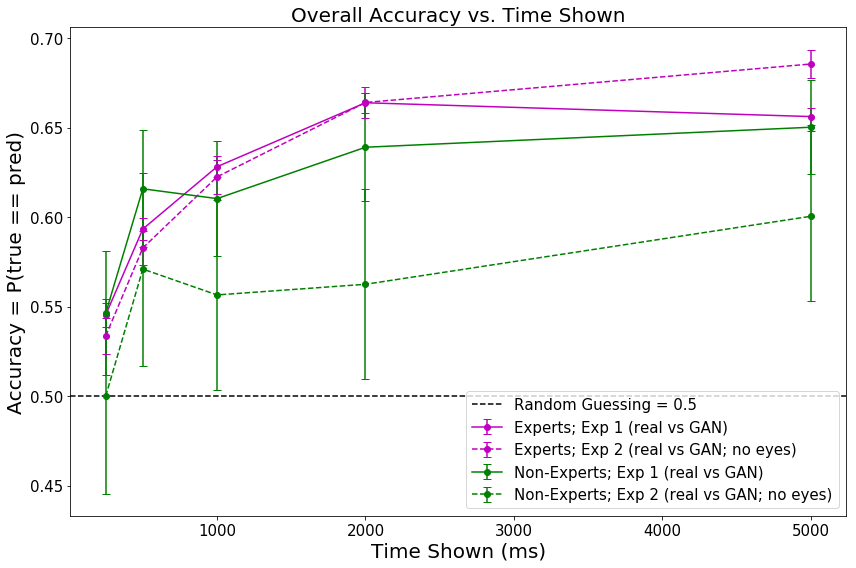

In [780]:
fig = plt.figure(figsize=(12,8))
fs = 20
tfs = 15
ax1 = fig.add_subplot(111)
ax1.set_title("Overall Accuracy vs. Time Shown", fontsize=fs)
ax1.set_xlabel("Time Shown (ms)", fontsize=fs)
ax1.set_ylabel("Accuracy = P(true == pred)", fontsize=fs)
# ax2 = fig.add_subplot(111)
# ax2.set_title("Fake Image FPR vs. Time Shown", fontsize=fs)
# ax2.set_xlabel("Time Shown (ms)", fontsize=fs)
# ax2.set_ylabel("FPR = P(pred=1|true=0)", fontsize=fs)

id_map = [
    (1, "Experts; Exp 1 (real vs GAN)", "m", "-", True), 
    (2, "Experts; Exp 2 (real vs GAN; no eyes)", "m", "--", True),
    (1, "Non-Experts; Exp 1 (real vs GAN)", "g", "-", False), 
    (2, "Non-Experts; Exp 2 (real vs GAN; no eyes)", "g", "--", False)
]

for (expt_id, label, color, linestyle, expert)  in id_map:
    exp_data = indiv_expert_results[(indiv_expert_results.expt_id == expt_id) & (indiv_expert_results.expert == expert)]
    ax1.errorbar(exp_data.duration, exp_data['accuracy'], yerr=exp_data['accuracy_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)
#     ax2.errorbar(exp_data.duration, exp_data['(pred=1|true=0)'], yerr=exp_data['(pred=1|true=0)_conf'],
#                  color=color, linestyle=linestyle, marker='o', label=label, capsize=4)

#     exp_data = results[results.expt_id == expt_id]
#     ax1.plot(exp_data.duration, exp_data.accuracy, color=color, linestyle=linestyle, marker='o', label=label)
#     ax2.plot(exp_data.duration, exp_data['(pred=1|true=0)'], color=color, linestyle=linestyle, marker='o', label=label)
    
#     print (exp_data.accuracy)

ax1.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax1.legend(loc=0, fontsize=tfs)
ax1.xaxis.set_tick_params(labelsize=tfs)
ax1.yaxis.set_tick_params(labelsize=tfs)

# ax2.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
# ax2.legend(loc=0, fontsize=tfs)
# ax2.xaxis.set_tick_params(labelsize=tfs)
# ax2.yaxis.set_tick_params(labelsize=tfs)

# fig.savefig('overall_acc.png')
plt.tight_layout()
plt.show()

1) Overall, what is the distribution of real vs. fake responses per duration
2) What are the component of the error (FPR, FNR)
3) When eyes are removed, do people think images are fake more often

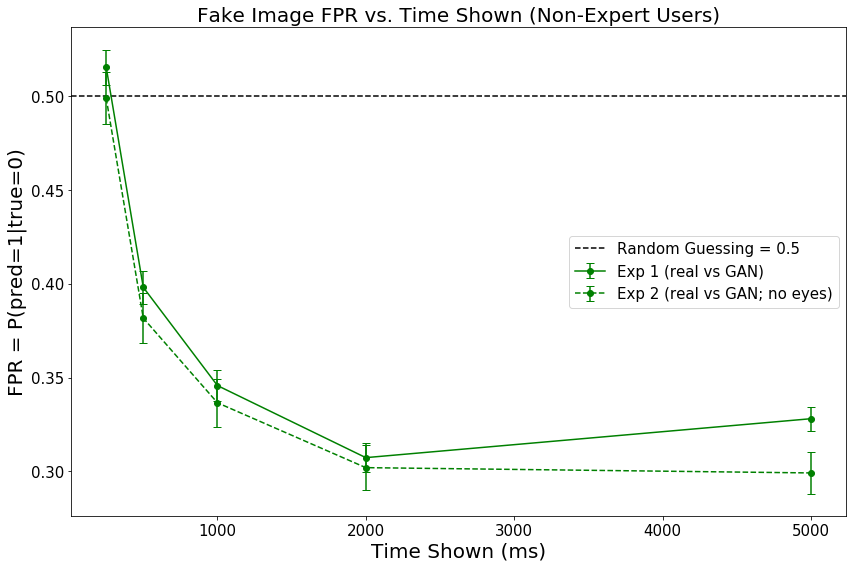

In [750]:
fig = plt.figure(figsize=(12,8))
fs = 20
tfs = 15
# ax1 = fig.add_subplot(111)
# ax1.set_title("Overall Accuracy vs. Time Shown (Non-Expert Users)", fontsize=fs)
# ax1.set_xlabel("Time Shown (ms)", fontsize=fs)
# ax1.set_ylabel("Accuracy = P(true == pred)", fontsize=fs)
ax2 = fig.add_subplot(111)
ax2.set_title("Fake Image FPR vs. Time Shown (Non-Expert Users)", fontsize=fs)
ax2.set_xlabel("Time Shown (ms)", fontsize=fs)
ax2.set_ylabel("FPR = P(pred=1|true=0)", fontsize=fs)

id_map = {
    1:("Exp 1 (real vs GAN)", "g", "-"), 
    2:("Exp 2 (real vs GAN; no eyes)", "g", "--")
}

for expt_id, (label, color, linestyle)  in id_map.items():
    exp_data = indiv_results[indiv_results.expt_id == expt_id]
#     ax1.errorbar(exp_data.duration, exp_data['accuracy'], yerr=exp_data['accuracy_conf'],
#                  color=color, linestyle=linestyle, marker='o', label=label, capsize=4)
    ax2.errorbar(exp_data.duration, exp_data['(pred=1|true=0)'], yerr=exp_data['(pred=1|true=0)_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)

#     exp_data = results[results.expt_id == expt_id]
#     ax1.plot(exp_data.duration, exp_data.accuracy, color=color, linestyle=linestyle, marker='o', label=label)
#     ax2.plot(exp_data.duration, exp_data['(pred=1|true=0)'], color=color, linestyle=linestyle, marker='o', label=label)
    
#     print (exp_data.accuracy)

# ax1.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
# ax1.legend(loc=0, fontsize=tfs)
# ax1.xaxis.set_tick_params(labelsize=tfs)
# ax1.yaxis.set_tick_params(labelsize=tfs)

ax2.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax2.legend(loc=0, fontsize=tfs)
ax2.xaxis.set_tick_params(labelsize=tfs)
ax2.yaxis.set_tick_params(labelsize=tfs)

# fig.savefig('overall_fpr_nonexpert.png')
plt.tight_layout()
plt.show()

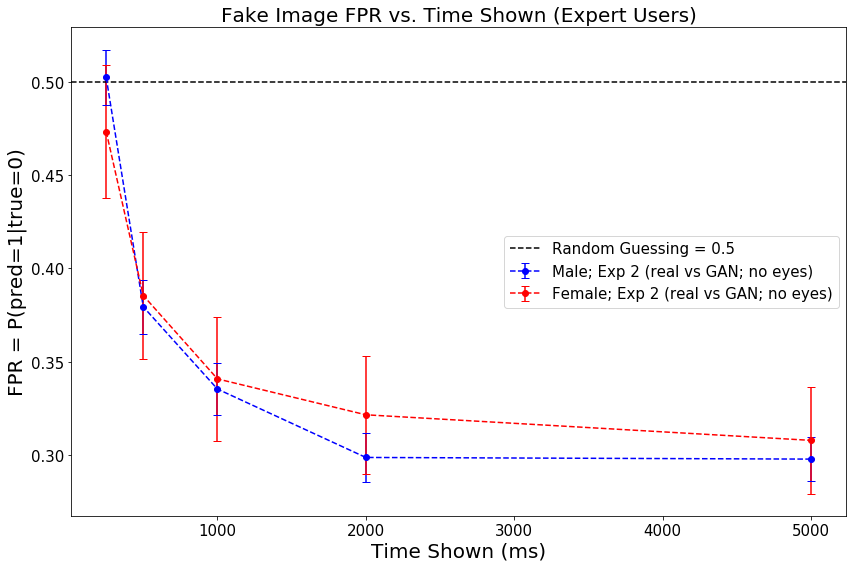

In [751]:
fs = 20
tfs = 15

fig = plt.figure(figsize=(12,8))
# ax1 = fig.add_subplot(111)
# ax1.set_title("Face Classification Overall Accuracy vs. Time Shown (Expert Users)", fontsize=fs)
# ax1.set_xlabel("Time Shown (ms)", fontsize=fs)
# ax1.set_ylabel("Accuracy = P(true == pred)", fontsize=fs)

ax2 = fig.add_subplot(111)
ax2.set_title("Fake Image FPR vs. Time Shown (Expert Users)", fontsize=fs)
ax2.set_xlabel("Time Shown (ms)", fontsize=fs)
ax2.set_ylabel("FPR = P(pred=1|true=0)", fontsize=fs)

gender_id_map = {
#     ('male', 1):("Male; Exp 1 (real vs GAN)", "b", "-"), 
    ('male', 2):("Male; Exp 2 (real vs GAN; no eyes)", "b", "--"),
#     ('female', 1):("Female; Exp 1 (real vs GAN)", "r", "-"), 
    ('female', 2):("Female; Exp 2 (real vs GAN; no eyes)", "r", "--")
}

for (gender, expt_id), (label, color, linestyle)  in gender_id_map.items():
    exp_data = indiv_gender_results[(indiv_gender_results.gender == gender) & (indiv_gender_results.expt_id == expt_id)]
#     ax1.errorbar(exp_data.duration, exp_data['accuracy'], yerr=exp_data['accuracy_conf'],
#                  color=color, linestyle=linestyle, marker='o', label=label, capsize=4)
    ax2.errorbar(exp_data.duration, exp_data['(pred=1|true=0)'], yerr=exp_data['(pred=1|true=0)_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)


# ax1.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
# ax1.legend(loc=0, fontsize=tfs)
# ax1.xaxis.set_tick_params(labelsize=tfs)
# ax1.yaxis.set_tick_params(labelsize=tfs)

ax2.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax2.legend(loc=0, fontsize=tfs)
ax2.xaxis.set_tick_params(labelsize=tfs)
ax2.yaxis.set_tick_params(labelsize=tfs)

# fig.savefig('gender_overall_fpr_expert_exp2.png')
plt.tight_layout()
plt.show()

In [725]:
print ("Exp 1, # datapoints: %d" % df[df.expt_id==1].id.count())
print ("Exp 2, # datapoints: %d" % df[df.expt_id==2].id.count())
print ("---------------------------------------------")
print(indiv_df.groupby(["expt_id", "duration"]).id.count().reset_index().sort_values(by=['expt_id','duration'], ascending=[True,False]))
print(indiv_df[indiv_df.gender != 'other'].groupby(["expt_id", "duration", "gender"]).id.count().reset_index().sort_values(by=['expt_id','duration'], ascending=[True,False]))

Exp 1, # datapoints: 4788
Exp 2, # datapoints: 1728
---------------------------------------------
   expt_id  duration   id
4        1      5000  213
3        1      2000  163
2        1      1000  148
1        1       500  141
0        1       250  133
9        2      5000   68
8        2      2000   56
7        2      1000   56
6        2       500   54
5        2       250   54
    expt_id  duration  gender   id
8         1      5000  female   73
9         1      5000    male  137
6         1      2000  female   63
7         1      2000    male   97
4         1      1000  female   59
5         1      1000    male   86
2         1       500  female   58
3         1       500    male   80
0         1       250  female   54
1         1       250    male   77
18        2      5000  female   34
19        2      5000    male   34
16        2      2000  female   26
17        2      2000    male   30
14        2      1000  female   26
15        2      1000    male   30
12        2       500

In [726]:
img_df = df.groupby('filename').agg({
    'id': 'count',
    'expt_id':'max',
    'correct': 'sum',
    'true': 'max'
}).reset_index()
img_df['accuracy'] = img_df.correct / img_df.id



gender_img_df = df.groupby(['filename', 'gender']).agg({
    'id': 'count',
    'expt_id':'max',
    'correct': 'sum',
    'true': 'max'
}).reset_index()
gender_img_df['accuracy'] = gender_img_df.correct / gender_img_df.id

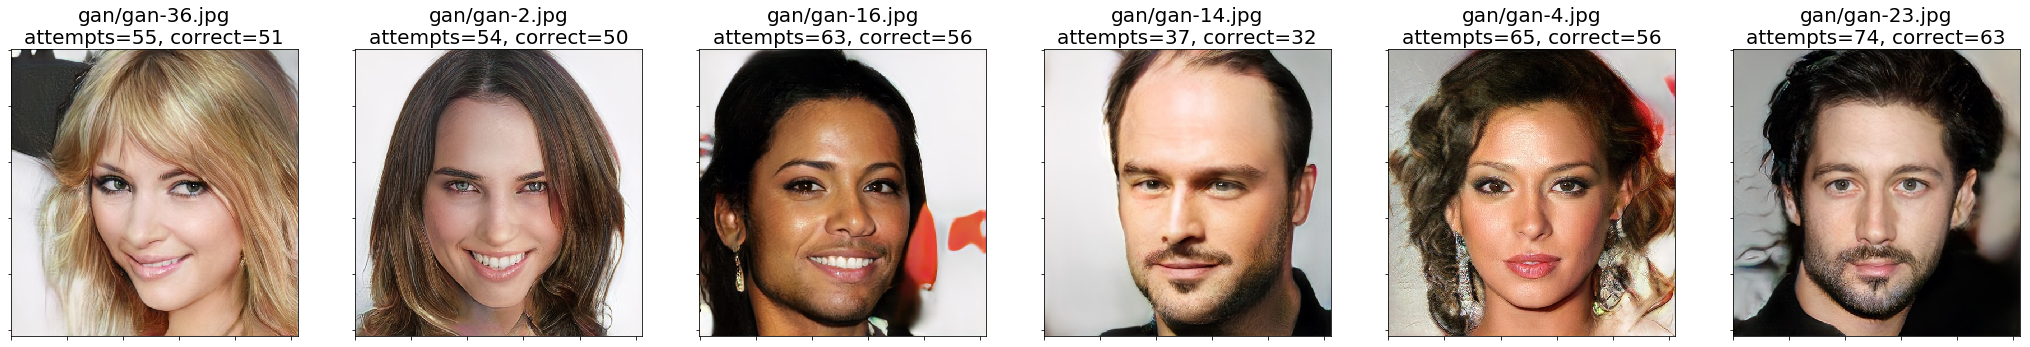

In [727]:
N = 6
expt_id = 1
true = 0
ascending = False

fs = 20

data = img_df[(img_df.true == true) & (img_df.expt_id == expt_id)].sort_values(by=['accuracy', 'id'], ascending=ascending).reset_index()

# plt.hist(data.accuracy, bins=10)
# plt.show()

fig = plt.figure(figsize=(36,6))
for i in range(N):
    ax = fig.add_subplot('%d%d%d' % (1,N,i+1))
    ax.set_title("%s\nattempts=%d, correct=%d" % (data.filename[i], data.id[i], int(data.correct[i])), fontsize=fs)
    filepath = os.path.join('./server/static', data.filename[i])
    ax.imshow(mpimg.imread(filepath))
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# fig.savefig('./final_plots/easy_fake_exp1_expert.png')
plt.show()

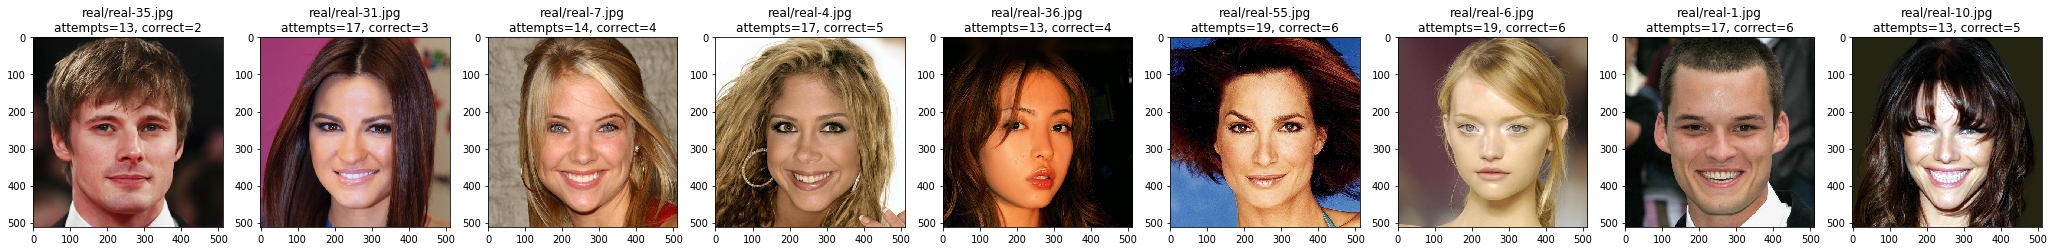

In [728]:
N = 9
true = 1
expt_id = 1
ascending = True
gender = 'female'

data = gender_img_df[(gender_img_df.true == true) & (gender_img_df.expt_id == expt_id) & (gender_img_df.gender == gender)].sort_values(by=['accuracy', 'id'], ascending=ascending).reset_index()

fig = plt.figure(figsize=(36,6))
for i in range(N):
    ax = fig.add_subplot('%d%d%d' % (1,N,i+1))
    ax.set_title("%s\nattempts=%d, correct=%d" % (data.filename[i], data.id[i], int(data.correct[i])))
    filepath = os.path.join('./server/static', data.filename[i])
    ax.imshow(mpimg.imread(filepath))

plt.show()

/home/abhinav/Documents/meng/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


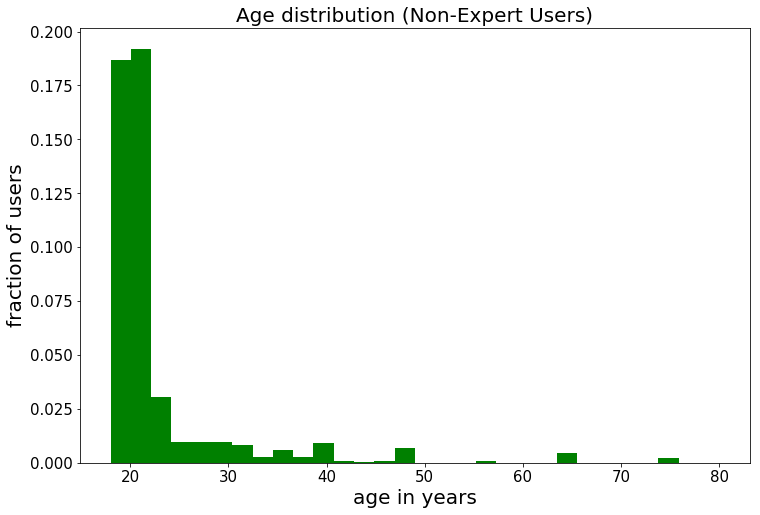

In [729]:
fs = 20
tfs = 15
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title("Age distribution (Non-Expert Users)", fontsize=fs)
ax.set_xlabel("age in years", fontsize=fs)
ax.set_ylabel("fraction of users", fontsize=fs)
ax.hist(df.age, bins=30, range=(18,80), color="g", normed=True)
ax.xaxis.set_tick_params(labelsize=tfs)
ax.yaxis.set_tick_params(labelsize=tfs)
# fig.savefig('age_nonexpert.png')
plt.show()

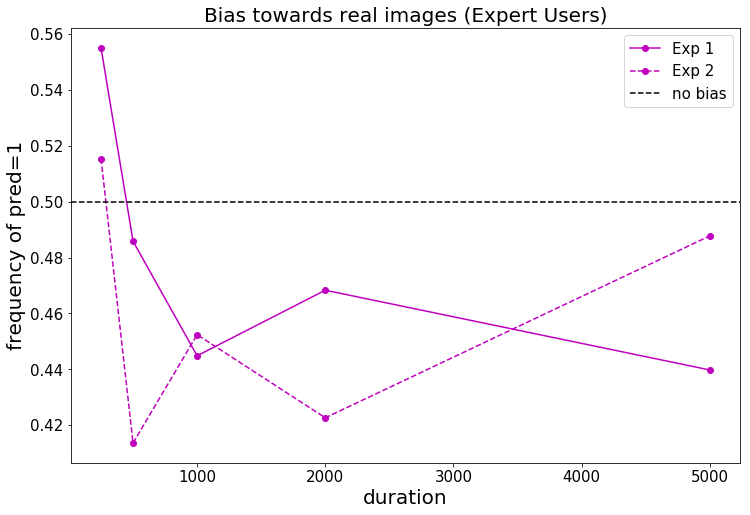

In [730]:
bias_df = df.groupby(['expt_id', 'duration']).pred.mean().reset_index()

fs = 20
tfs = 15

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for expt_id, style in [(1, '-'),(2, '--')]:
    data = bias_df[bias_df.expt_id == expt_id].sort_values(by="duration", ascending=True)
    ax.plot(data.duration, data.pred, color='m', marker="o", linestyle=style, label="Exp %d" % expt_id)
    
ax.axhline(y=0.5, color="k", linestyle="--", label="no bias")
ax.set_title("Bias towards real images (Expert Users)", fontsize=fs)
ax.set_xlabel("duration", fontsize=fs)
ax.set_ylabel("frequency of pred=1", fontsize=fs)
ax.legend(loc=0, fontsize=tfs)
ax.xaxis.set_tick_params(labelsize=tfs)
ax.yaxis.set_tick_params(labelsize=tfs)

fig.savefig('bias_expert.png')
plt.show()    


,expt_id,duration,age,gender,id,true,accuracy,(pred=1|true=1),(pred=0|true=1),(pred=1|true=0),(pred=0|true=0)
0,1,5000,20,male,6,3,0.833333,0.666667,0.333333,0.000000,1.000000
1,1,2000,20,male,6,3,0.833333,1.000000,0.000000,0.333333,0.666667
2,1,1000,20,male,6,3,0.500000,1.000000,0.000000,1.000000,0.000000
3,1,500,20,male,6,3,0.500000,0.666667,0.333333,0.666667,0.333333
4,1,250,20,male,6,3,0.333333,0.666667,0.333333,1.000000,0.000000
5,1,5000,21,male,6,3,1.000000,1.000000,0.000000,0.000000,1.000000
6,1,2000,21,male,6,3,0.666667,0.666667,0.333333,0.333333,0.666667
7,1,5000,20,female,6,3,0.500000,0.333333,0.666667,0.333333,0.666667
8,1,2000,20,female,6,3,0.833333,1.000000,0.000000,0.333333,0.666667
9,1,1000,20,female,6,3,0.666667,0.666667,0.333333,0.333333,0.666667
